# Dragonfruit AI Assessment - 2

This is the second part of the assessment. Here, we answer all the questions shared via email.

## Questions

The submission is more complex than it needs to be.  For CSR, why not use an existing library?  Are there other representations for the dye images that could possibly be more storage efficient?  How would such approaches impact performance?  Why is the simulated dye image diffuse instead of what you would expect, simple curvy lines representing veins with some scattered bits of dye in other places including outside the parasite body?

#### Answer:

The solution presented in the [first round](https://github.com/NikhilKamathB/Co-curricular/blob/master/OA/DragonfruitAI/Nikhil%20Bola%20Kamath%20-%20DragonfruitAI.ipynb) dosen't use CSR for encoding/compressing the image, it uses run-length encoding. However, for this round we shall be using sparse matrix representation for the implementation. To the best of my knowledge, a space matrix can be represented using the following formats: CSR, CSC, Diagonal storage, Dictionary of keys (DOK), Coordinate list (COO) and list of lists (LIL). Because, in our task we will be needing to construct the compressed image, COO is a better fit. For any later matrix operations, we can convert the COO to CSR/CSC format for efficent processing. To achieve all of this, we shall make use of the python scipy library.

Sparse matrix representations aim to exploit the fact that many elements in the matrix are zeros to save space and potentially improve computational performance. Sparse representations can significantly reduce the memory footprint. Formats like CSR (Compressed Sparse Row) and CSC (Compressed Sparse Column) are designed to facilitate fast matrix-vector multiplication. COO, DOK, etc on the other hand is very much beneficial for performing element-wise operations including updation, deletion and insertion. Methods like DOK enable faster searching which can be done O(1). Libraries like SciPy have optimized implementations for sparse matrix operations which can be much faster than normal implementations.

The Part 1, generates simulated microscope and dye sensor images. In this version, the dye spread has been represented like that of the human veins.

The Part 2, defines the encoding and decoding function. For this round, I have further improved the encoding and the decoding process significantly, when compared to the previous round, by introducing threading and processing on shards rather than the whole image. The compressed item not consumes space somewhere around 0.24 KB.

The Part 3 is taken from the previous round which address the problem of identifying cancer in the parasite.

### Part 0

In [1]:
# import necessary libraries
import sys
import cv2
import math
import copy
import random
import threading
import numpy as np
from scipy import sparse
from scipy import signal
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from collections import defaultdict
from scipy.sparse import coo_matrix

### Part 1

In [2]:
def generate_microscope_image(rows: int = 128, cols: int = 128, min_coverage: float = 0.25, max_coverage: float = 0.75, k: tuple = (3, 3), resize: tuple = (100000, 100000)) -> tuple:
    '''
        This funciton geenrates an image similar to one generated by the microscope.
        Input params: rows - height of the sample image
                      cols - width of the sample image
                      min_coverage - minimum fraction occupied by the blob in the image
                      max_coverage - maximum fraction occupied by the blob in the image
                      k - kernel size
                      resize - size of the true image to be generated
        Returns: tuple - (sample iamge, scaled sample image)
    '''
    img = np.zeros((rows, cols), dtype=np.uint8)
    kernel = np.ones(k, dtype=np.uint8)
    kernel[k[0]//2, k[1]//2] = 0
    x = random.randint(0, rows-1)
    y = random.randint(0, cols-1)
    img[x, y] = 1
    steps = random.randint(int(min_coverage * rows * cols), int(max_coverage * rows * cols))
    ctr = 0
    while ctr <= steps:
        candidate = signal.convolve2d(img, kernel, mode='same')
        mask = (img == 1) & (candidate < 8)
        mask = np.argwhere(mask)
        x, y = mask[np.random.choice(len(mask))]
        direction = np.random.choice(8)
        if direction == 0: # N
            x = x - 1
        elif direction == 1: # E 
            y = y + 1
        elif direction == 2: # S
            x = x + 1
        elif direction == 3: # W
            y = y - 1
        elif direction == 4: # NE 
            x = x - 1
            y = y + 1
        elif direction == 5: # SE
            x = x + 1
            y = y + 1
        elif direction == 6: # SW
            x = x + 1
            y = y - 1
        elif direction == 7: # NW
            x = x - 1
            y = y - 1
        if 0 <= x < rows and 0 <= y < cols and img[x, y] == 0:
            img[x, y] = 1
            ctr += 1
        if ctr == steps:
            break
    return ((1-img), cv2.resize((1-img), resize))

def generate_dye_sensor_image(microscope_img: np.ndarray, rows:int = 128, cols: int = 128, dye_depth:int = 7, dye_width:int = 0.5, kernel_size_frac:float = 0.5, dye_spread_count:tuple = (2, 4), resize: tuple = (100000, 100000)) -> tuple:
    '''
        This funciton genrates an image similar to one generated by the dye sensor.
        Input params: microscope_img - sample generated image by the microscope 
                      rows - height of the sample image
                      cols - width of the sample image
                      dye_depth - number of times sampling happens
                      dye_width - thickness of the dye segment
                      kernel_th_frac - threshold for genrating mask
                      dye_spread_count - number of times dye segmented must be generated
                      resize - size of the true image to be generated
        Returns: tuple - (sample iamge, scaled sample image)
    '''
    
    def draw_vein(draw, start, length, angle, width, depth, exceptions, n_branch=[1, 3], scatter=10):
        '''
            This function draws veins like segments, if the sampling happens to be outside blob, then we sample scattered bits
        '''
        if depth <= 0: return
        end = (start[0] + length*math.cos(angle), start[1] + length*math.sin(angle))
        if [int(start[0]), int(start[1])] not in exceptions:
            draw.line([start, end], fill='blue', width=int(width))
        for _ in range(random.choice(n_branch)):
            new_angle = angle + random.uniform(-math.pi/random.randint(3, 6), math.pi/random.randint(3, 6))
            new_length = length * random.uniform(0.6, 0.8)
            new_width = width * random.uniform(0.6, 0.8)
            if [int(end[0]), int(end[1])] not in exceptions:
                draw_vein(draw, end, new_length, new_angle, new_width, depth-1, exceptions)
            else:
                for _ in range(random.randint(1, scatter)):
                    distance = random.uniform(0, random.uniform(0, 2*math.pi))
                    draw.point((end[0]+random.uniform(0, 10)*math.cos(new_angle), end[0]+random.uniform(0, 10)*math.sin(new_angle)), fill="blue")
                draw_vein(draw, end, new_length, new_angle, new_width, depth-2, exceptions)
    
    dye_image = Image.new('RGB', (rows, cols), color='white')
    draw = ImageDraw.Draw(dye_image)
    kernel_size = random.randint(20, int(microscope_img.shape[0] * kernel_size_frac))
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    candidate = signal.convolve2d(microscope_img, kernel, mode='same')
    for _ in range(random.randint(dye_spread_count[0], dye_spread_count[1])):
        mask = (microscope_img == 0) & (candidate == 0)
        mask = np.argwhere(mask)
        if len(mask) > 0:
            x, y = mask[np.random.choice(len(mask))]
        else:
            x = random.randint(0, microscope_img.shape[1])
            y = random.randint(0, microscope_img.shape[0])
        start = (x, y)
        angle = random.uniform(-math.pi/2, math.pi/2)
        length = random.uniform(min(rows, cols) * 0.1, min(rows, cols) * 0.25)
        draw_vein(draw, start, length, angle, dye_width, dye_depth, np.argwhere(microscope_img == 1).tolist())
    dye_image = np.array(dye_image, dtype=np.uint8)
    dye_image = cv2.cvtColor(dye_image, cv2.COLOR_RGB2GRAY)
    return (dye_image, cv2.resize(np.float32(dye_image), resize).astype(np.uint8))

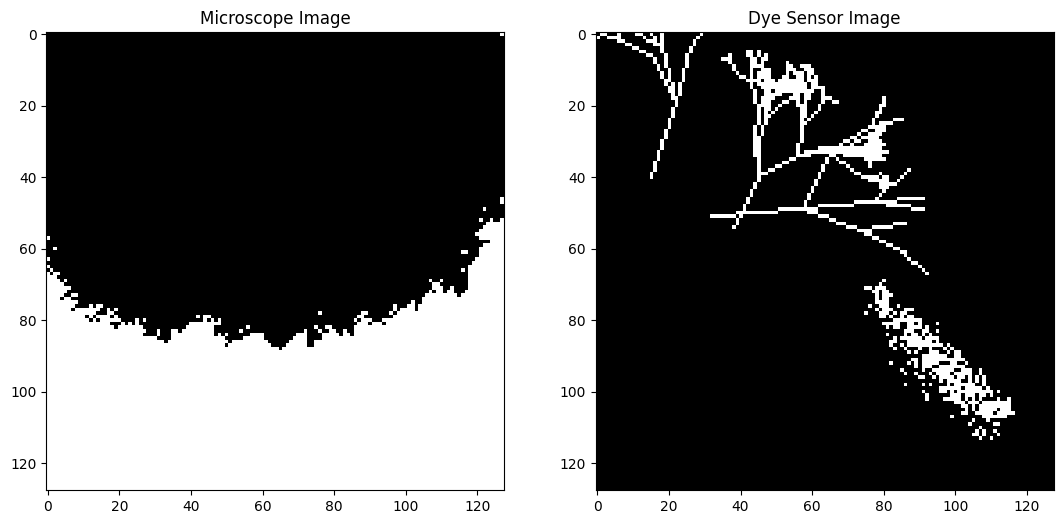

CPU times: user 30.8 s, sys: 22.7 s, total: 53.5 s
Wall time: 27.7 s


In [6]:
%%time
# Visualization of the generated image
true_microscope_img, resized_microscope_img = generate_microscope_image()
true_dye_sensor_img, resized_dye_sensor_img = generate_dye_sensor_image(true_microscope_img)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 13))
ax1.imshow(true_microscope_img, cmap="gray")
ax1.set_title("Microscope Image")
ax2.imshow(np.int8(true_dye_sensor_img), cmap="gray")
ax2.set_title("Dye Sensor Image")
plt.show()

### Part 2

The following cell defines a function that encodes and decodes image based on the COO format. We use the Scipy library to achieve this.

In [7]:
# Store in our data structure | list using COO.
def encode_image(img: np.ndarray, shards: int = 5, with_thresholding: bool = False) -> dict:
    '''
        This funciton encodes a given image using COO.
        Input params: img - image to encode
                      shards - number of segments to be done on image
                      with_thresholding - bool value, whether to apply thresholding to the image or not
        Returns: dict - encoded item
    '''
    if with_thresholding: 
        img = cv2.threshold(np.float32(img), 100, 255, cv2.THRESH_BINARY_INV)[1]
        img /= 255
    img = img.astype(np.uint8)
    data = defaultdict()
    splits = np.linspace(0, img.shape[0], shards).astype(int)
    
    def process_img(idx, start_idx, end_idx):
        data[idx] = coo_matrix(img[start_idx: end_idx, :])
    
    threads = [threading.Thread(target=process_img, args=(i, splits[i-1], splits[i])) for i in range(1, len(splits))]
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    return data

def decode_image(data: dict, width: int = 100000, height: int = 100000, shards: int = 5) -> np.ndarray:
    '''
        This funciton decodes a given a dict of compressed image.
        Input params: record - encoded image
                      width - width of the image
                      height - height of the image
                      shards - number of segments to be done on image
        Returns: numpy array - decoded image
    '''
    
    splits = np.linspace(0, height, shards).astype(int)
    img = np.ones((height, width), dtype=np.uint8)

    def process_record(instance, start_idx, end_idx):
        img[start_idx: end_idx, :] = instance[1].toarray()
        
    data_list = list(defaultdict(int, sorted(data.items())).items())
    threads = [threading.Thread(target=process_record, args=(data_list[i-1], splits[i-1], splits[i])) for i in range(1, len(splits))]
    for t in threads:
        t.start()
    for t in threads:
        t.join()
    return img

In [8]:
%%time
encoded_microscope_img = encode_image(resized_microscope_img)
print(f"Size of image from microscope in GB = {resized_microscope_img.nbytes/1e+9} GB")
print(f"Size of image from microscope in GB, after compressing = {float(sys.getsizeof(encoded_microscope_img)/1e+3)} KB")

Size of image from microscope in GB = 10.0 GB
Size of image from microscope in GB, after compressing = 0.24 KB
CPU times: user 55.2 s, sys: 39.4 s, total: 1min 34s
Wall time: 1min 2s


In [9]:
%%time
recovered_resized_microscope_img = decode_image(encoded_microscope_img)

CPU times: user 3.05 s, sys: 4.78 s, total: 7.83 s
Wall time: 4.34 s


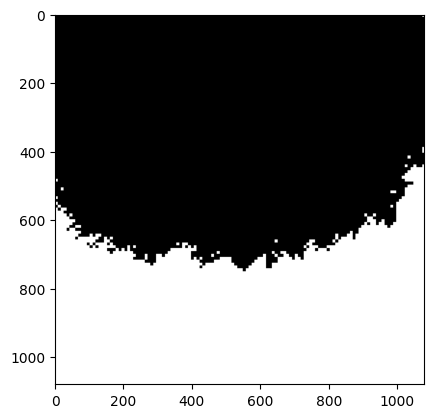

In [10]:
# Visualization of the recovered microscope image
plt.imshow(cv2.resize(recovered_resized_microscope_img, (1080, 1080)), cmap="gray")

In [11]:
# Validating whether the recovered image is the same as the generated image
np.array_equal(resized_microscope_img, recovered_resized_microscope_img)

True

In [12]:
%%time
encoded_dye_sensor_img = encode_image(resized_dye_sensor_img, with_thresholding=True)
print(f"Size of image from microscope in GB = {resized_dye_sensor_img.nbytes/1e+9} GB")
print(f"Size of image from microscope in GB, after compressing = {float(sys.getsizeof(encoded_dye_sensor_img)/1e+3)} KB")

Size of image from microscope in GB = 10.0 GB
Size of image from microscope in GB, after compressing = 0.24 KB
CPU times: user 36 s, sys: 1min 3s, total: 1min 39s
Wall time: 47.6 s


In [13]:
%%time
recovered_resized_dye_img = decode_image(encoded_dye_sensor_img)

CPU times: user 973 ms, sys: 2.13 s, total: 3.1 s
Wall time: 1.59 s


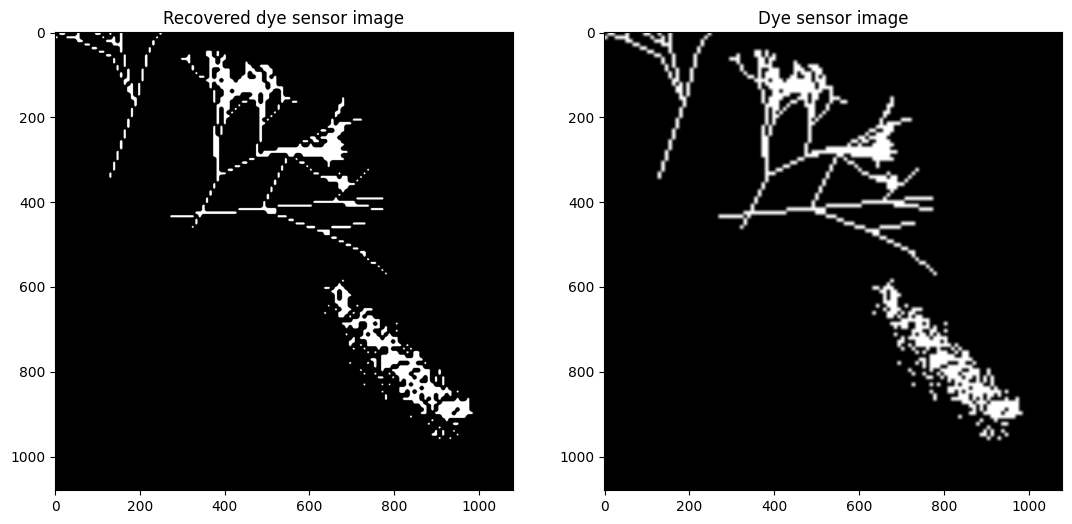

In [14]:
# Visualization of the recovered dye sensor image after thresholding
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 13))
ax1.imshow(cv2.resize(recovered_resized_dye_img, (1080, 1080)), cmap="gray")
ax1.set_title("Recovered dye sensor image")
ax2.imshow(1-cv2.resize(resized_dye_sensor_img, (1080, 1080)), cmap="gray")
ax2.set_title("Dye sensor image")
plt.show()

### Part 3

Using the simulated images generated by the code above as input, we check if the parasite has cancer or not. This section of the code is taken from the previous round.

In [15]:
resize_to = (2000, 2000)
resized_to_microscope_img = cv2.resize(recovered_resized_microscope_img, resize_to)
resized_to_dye_sensor_img = cv2.resize(recovered_resized_dye_img, resize_to)

In [16]:
%%time
cancer_img = cv2.bitwise_and(resized_to_dye_sensor_img, resized_to_dye_sensor_img, mask = 1-resized_to_microscope_img)

CPU times: user 5.94 ms, sys: 8.37 ms, total: 14.3 ms
Wall time: 11.2 ms


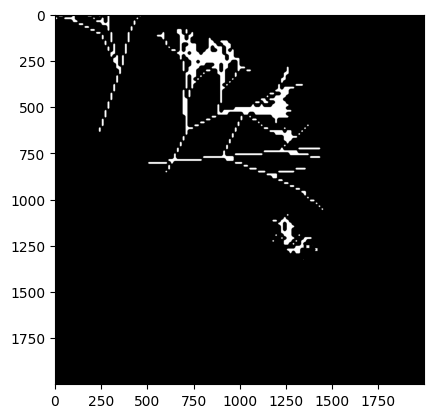

In [17]:
plt.imshow(cancer_img, cmap="gray")

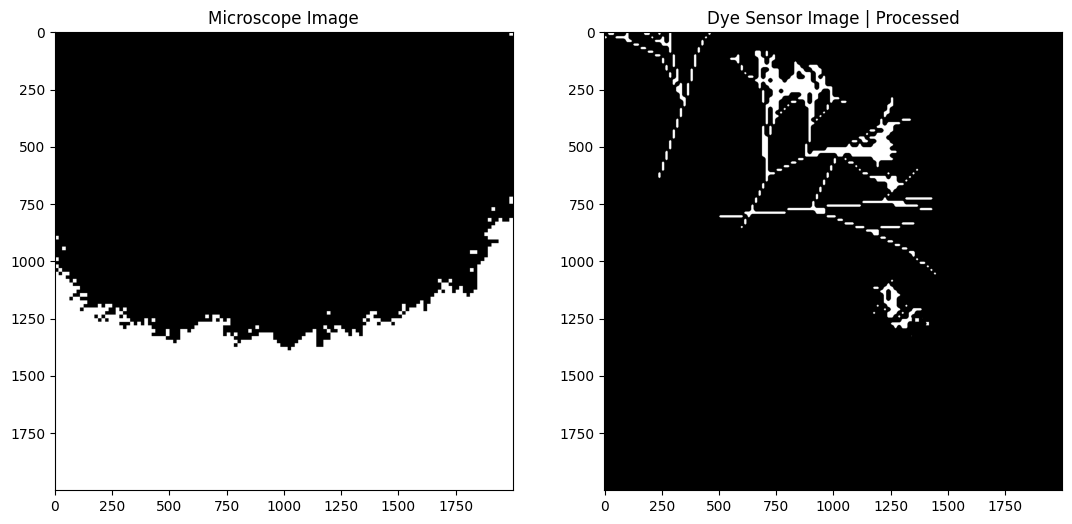

CPU times: user 818 ms, sys: 11.9 ms, total: 829 ms
Wall time: 303 ms


In [18]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 13))
ax1.imshow(resized_to_microscope_img, cmap="gray")
ax1.set_title("Microscope Image")
ax2.imshow(cancer_img, cmap="gray")
ax2.set_title("Dye Sensor Image | Processed")
plt.show()


In [19]:
%%time
# A parasite is deemed to have cancer if the total amount of dye detected in its body exceeds 10% of the area occupied by the parasite in the image.
ones_dye_coverage = np.sum(cancer_img==1)
zeros_blob_coverage = np.sum(resized_to_microscope_img==0)
diffusion_percentage = (ones_dye_coverage / zeros_blob_coverage) * 100
print("Number of ones in dye: ", ones_dye_coverage)
print("Number of zeros in blob: ", zeros_blob_coverage)
if diffusion_percentage >= 10:
    print(f"The parasite has cancer | diffusion percentage = {diffusion_percentage}.")
else:
    print("The parasite does not have cancer.")

Number of ones in dye:  116999
Number of zeros in blob:  2446971
The parasite does not have cancer.
CPU times: user 13.7 ms, sys: 5.75 ms, total: 19.4 ms
Wall time: 15.6 ms
